Author: Daniel Lusk, University of Potsdam

Inspired by: Ankit Kariryaa ([github repo](https://github.com/ankitkariryaa/An-unexpectedly-large-count-of-trees-in-the-western-Sahara-and-Sahel))

### Overview

TODO: Write overview

### Getting started

TODO: Write getting started

In [87]:
import glob
import os

import matplotlib.pyplot as plt
import numpy as np
import tifffile as tiff

from config import Preprocessing
from skimage.io import imshow
from skimage.measure import label, regionprops
from skimage.morphology import erosion
from scipy.ndimage import distance_transform_edt
from tqdm import tqdm_notebook as tqdm

import warnings  # ignore annoying warnings
warnings.filterwarnings("ignore")

# Magic commands
%matplotlib inline
%reload_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Load configuration and get image directories

In [89]:
config = Preprocessing.Config()
im_dirs = glob.glob(os.path.join(config.data_dir_path, "*"))

Calculate and write NDVI

In [90]:
def calculate_and_write_ndvi(d):
    """Takes an image directory, locates the RGBI image, calculates the corresponding
    NDVI layer, and writes that layer to the NDVI subdirectory.

    Args:
        d (str): Path of image directory
    """
    im_id = os.path.basename(d)
    rgbi = tiff.imread(glob.glob(os.path.join(d, f"{config.rgbi_dn}/*{config.image_file_ext}"))[0])
    red = rgbi[..., 0] / 255.  # Normalize and convert to float to avoid div by zero issues
    nir = rgbi[..., -1] / 255.

    # Allow division by zero
    # np.seterr(divide="ignore", invalid="ignore")

    # Calculate NDVI
    ndvi = (nir.astype(float) - red.astype(float)) / (nir + red)

    # Write NDVI to disk
    ndvi_dir_path = os.path.join(d, config.ndvi_dn)
    if not os.path.exists(ndvi_dir_path):
        os.makedirs(ndvi_dir_path)
    tiff.imwrite(
        os.path.join(
            ndvi_dir_path, f"{im_id}_{config.ndvi_suffix}{config.image_file_ext}"
        ),
        ndvi
    )
    

for d in tqdm(im_dirs):
    calculate_and_write_ndvi(d)

  0%|          | 0/360 [00:00<?, ?it/s]

Load labels, erode, and convert to binary mask (this may take a while)

In [47]:
def erode_labels(d, bool_mask=False):
    """Takes an image directory, locates the labels image, erodes each tree by 1px,
    and returns a 2D image of the resulting eroded labels with their ids or as a
    boolean mask.

    Args:
        d (str): Path of image directory

    Returns:
        np.array: Eroded labels with ids or as boolean mask. A 2D array of shape
        (labels.height, labels.width)
    """
    labels = tiff.imread(
        glob.glob(os.path.join(d, config.label_dn, f"*{config.image_file_ext}"))[0]
    )
    labels = label(labels) # Ensure label count == region count
    regions = regionprops(labels)  # Get regions with props
    eroded_labels = np.zeros_like(labels)
    
    for i in range(1, labels.max()):
        label_i = regions[i].label
        eroded = erosion(labels == label_i)
        eroded_labels[eroded] = label_i

    if bool_mask:
        eroded_labels = eroded_labels > 0
        
    return eroded_labels

# Erode the labels to ensure boundaries between each one
eroded_labels = np.zeros((len(im_dirs), 512, 512))

for i, d in tqdm(enumerate(im_dirs), total=len(im_dirs)):
    eroded_labels[i] = erode_labels(d)

  0%|          | 0/360 [00:00<?, ?it/s]

In [52]:
###########################################################################
# Acknowledgements:
# The code was taken and adapted from Rok Mihevc (rok/unet_weight_map.py).
# https://gist.github.com/rok/5f4314ed3c294521456c6afda36a3a50
###########################################################################

def calculate_boundary_weights(labels, wc=None, w0 = 10, sigma = 5):
    """
    Generate weight maps as specified in the U-Net paper
    for boolean mask.
    
    "U-Net: Convolutional Networks for Biomedical Image Segmentation"
    https://arxiv.org/pdf/1505.04597.pdf
    
    Parameters
    ----------
    y: Numpy array
        2D array of shape (image_height, image_width) representing boolean (or binary)
        mask of objects.
    wc: dict
        Dictionary of weight classes.
    w0: int
        Border weight parameter.
    sigma: int
        Border width parameter.
    Returns
    -------
    Numpy array
        Training weights. A 2D array of shape (image_height, image_width).
    """
    
    # Check if mask is boolean or binary mask
    if len(np.unique(labels)) == 2:
        labels = label(labels)
        
    no_labels = labels == 0
    label_ids = sorted(np.unique(labels))[1:]

    if len(label_ids) > 1:
        distances = np.zeros((labels.shape[0], labels.shape[1], len(label_ids)))

        for i, label_id in enumerate(label_ids):
            distances[:,:,i] = distance_transform_edt(labels != label_id)

        distances = np.sort(distances, axis=2)
        d1 = distances[:,:,0]
        d2 = distances[:,:,1]
        w = w0 * np.exp(-1/2*((d1 + d2) / sigma)**2) * no_labels
        
        if wc:
            class_weights = np.zeros_like(labels)
            for k, v in wc.items():
                class_weights[labels == k] = v
            w = w + class_weights
    else:
        w = np.zeros_like(labels)
    
    return w

Create and write the weights images.

In [58]:
# Set the weights
wc = {
    0: 1, # background
    1: 0  # objects
}  

weight_maps = np.zeros_like(eroded_labels)

for i, (el, d) in tqdm(enumerate(zip(eroded_labels, im_dirs)), total=len(im_dirs)):
    im_id = im_id = os.path.basename(d)

    if len(el.shape) == 3:
        el = np.squeeze(el, -1)

    w = calculate_boundary_weights(el, wc)
    weight_maps[i] = w

    # Write weights to disk
    weights_dir_path = os.path.join(d, config.boundary_weights_dn)
    if not os.path.exists(weights_dir_path):
        os.makedirs(weights_dir_path)
    tiff.imwrite(
        os.path.join(
            weights_dir_path, f"{im_id}_{config.boundary_suffix}{config.image_file_ext}"
        ),
        w
    )


  0%|          | 0/360 [00:00<?, ?it/s]

Inspect some random weights files for sanity check

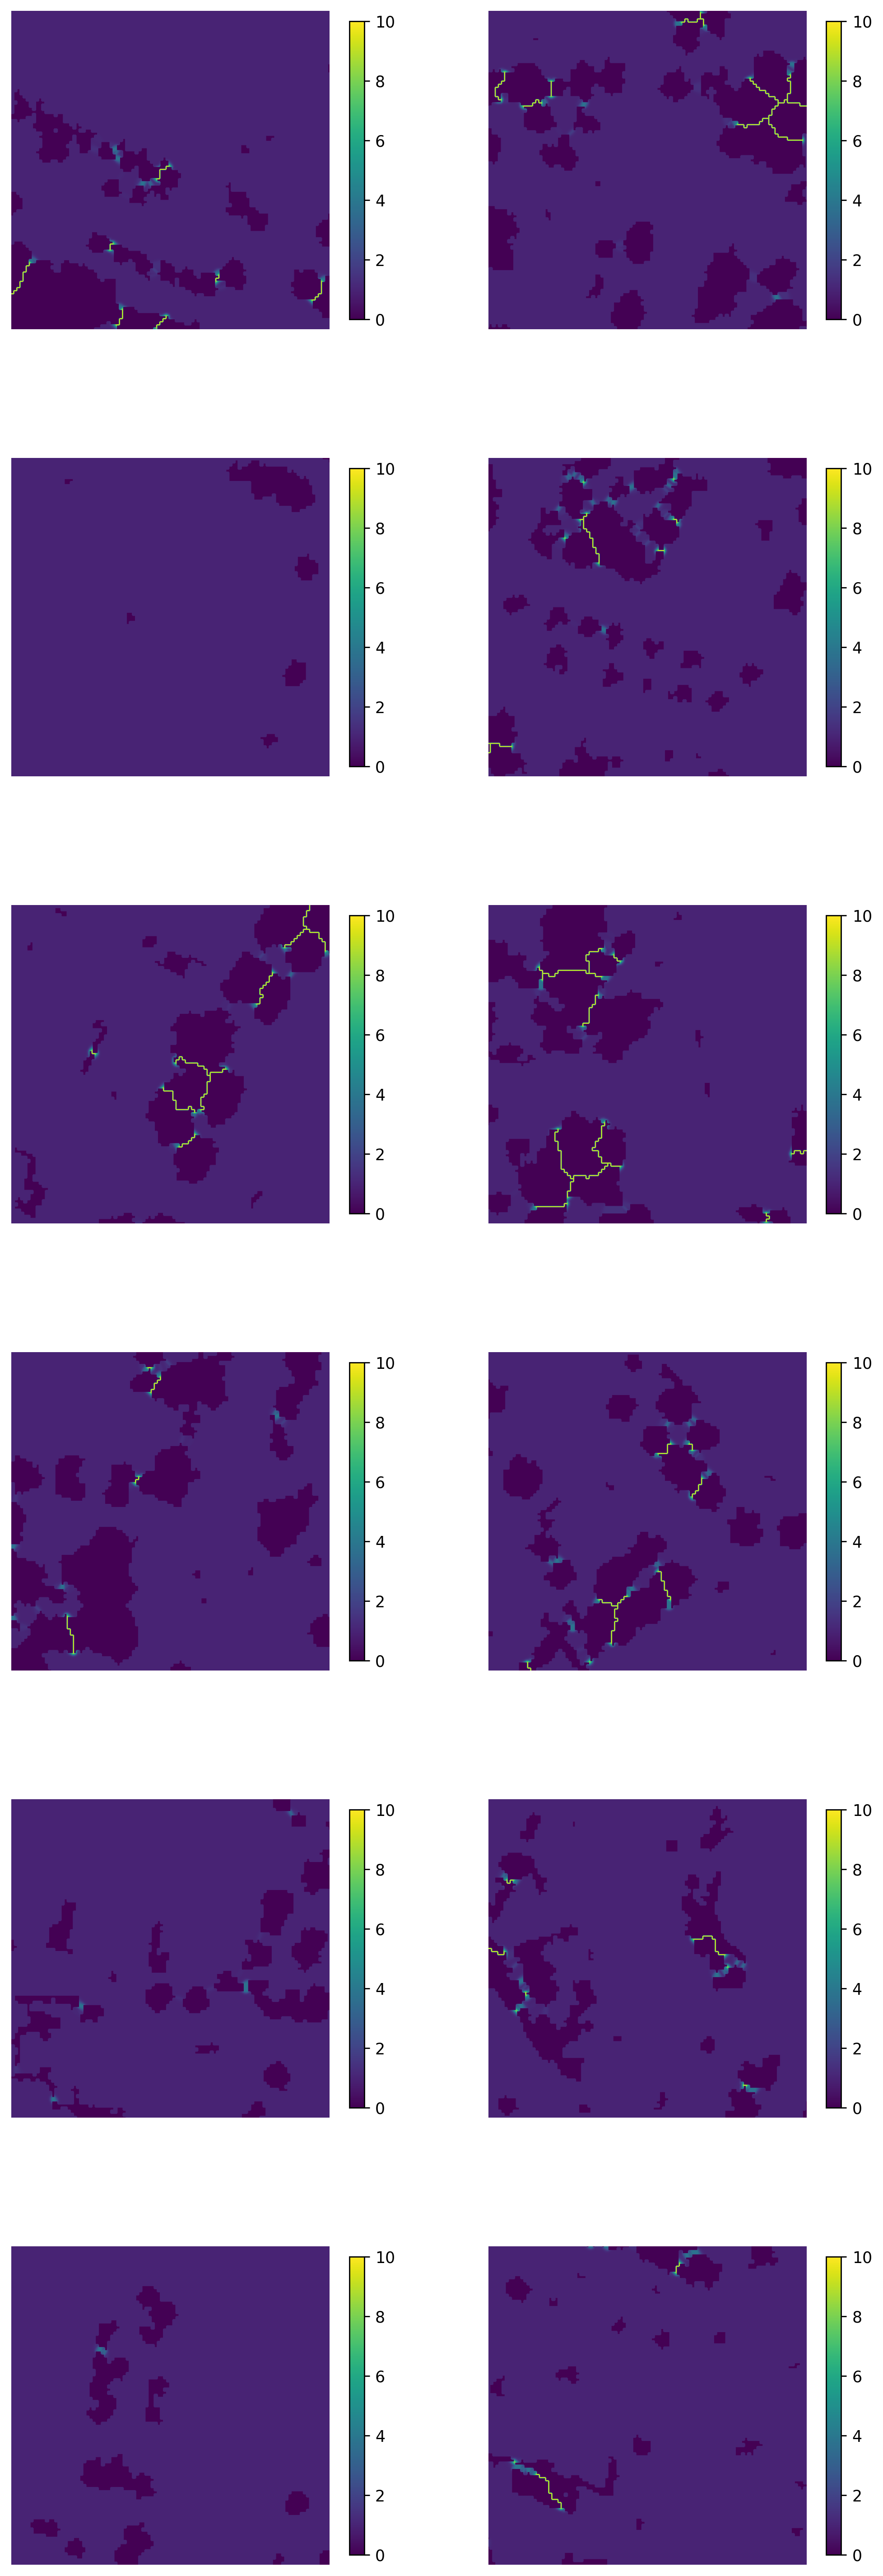

In [86]:
fig, ax = plt.subplots(6, 2, figsize=(10, 30), dpi=250)
ax = ax.ravel()

for a in ax:
    k = np.random.randint(0, len(weight_maps))
    im = a.imshow(weight_maps[k], vmin=0, vmax=10)
    plt.colorbar(im, ax=a, shrink=0.8)
    a.axis("off")
plt.show();